In [268]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import utils
from scipy.stats import multivariate_normal
from sklearn.ensemble import RandomForestClassifier

Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [269]:
maxX = 7
maxY = 7

def create_grid():
  return np.mgrid[-maxX:maxX:.1, -maxY:maxY:.1]

In [270]:
# Распределение 1
_dist1_comp_1 = multivariate_normal([-2,2], [[7, 0], [-1, 2]])
_dist1_comp_2 = multivariate_normal([2,1], [[4, 1], [1, 2]])

def prob_1(pos):
  return _dist1_comp_1.pdf(pos) + _dist1_comp_2.pdf(pos)

In [271]:
# Распределение 2
_dist2_comp_1 = multivariate_normal([3,0], [[2, 1], [1, 2]])
_dist2_comp_2 = multivariate_normal([0,-2], [[4, 1], [1, 2]])
_dist2_comp_3 = multivariate_normal([-1,-1], [[4, 1], [1, 2]])

def prob_2(pos):
  return _dist2_comp_1.pdf(pos) + _dist2_comp_2.pdf(pos) + _dist2_comp_3.pdf(pos)

In [272]:
x, y = create_grid()
pos = np.dstack((x, y))

In [273]:
maxProb1 = np.max(prob_1(pos))
maxProb2 = np.max(prob_2(pos))

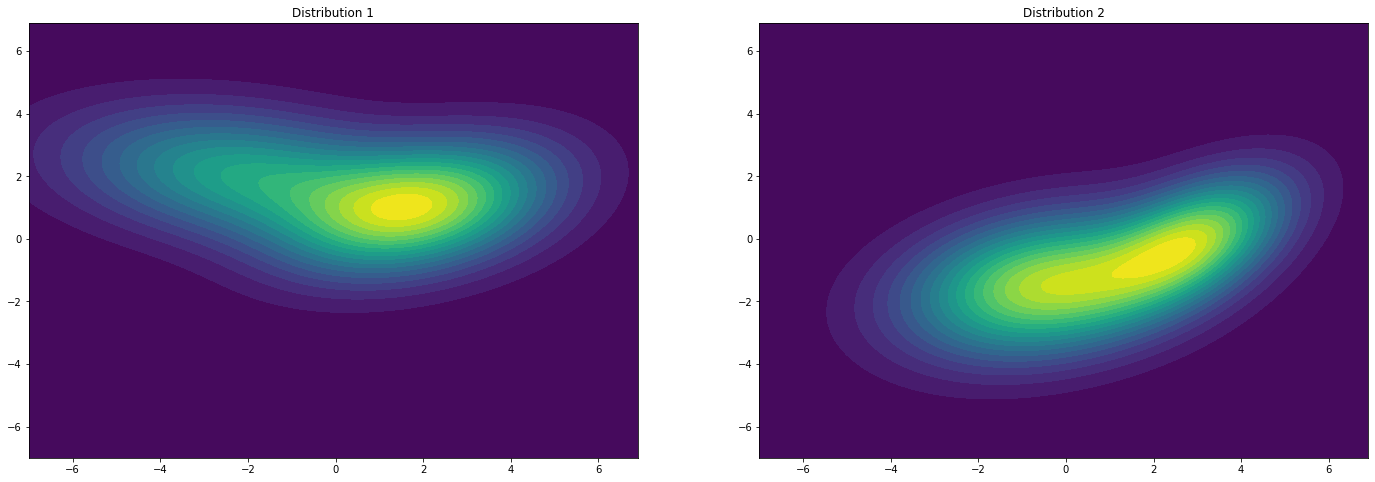

In [274]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Distribution 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)

ax2 = fig.add_subplot(122)
ax2.set_title('Distribution 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)

plt.show()

Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.

In [275]:
def generate_samples(prob, max_prob, size, target):
  samples = []
  while len(samples) != size:
    randX = np.random.uniform(-maxX, maxX, 1)[0]
    randY = np.random.uniform(-maxY, maxY, 1)[0]
    randProb = np.random.uniform(0.0, 1.0, 1)[0]
    sample_prob = prob([randX, randY])
    if (sample_prob / max_prob > randProb):
      samples.append([target, randX, randY])
  return np.array(samples)

def generate_dataset(size):
  size1 = round(np.random.normal(size / 2, 7, 1)[0])
  if size1 <= 0 or size1 > size:
    size1 = round(size / 2)

  samples1 = generate_samples(prob_1, maxProb1, size1, 1)
  samples2 = generate_samples(prob_2, maxProb2, size - size1, 2)

  print(f"Created samples: {size}")
  print(f"Samples ratio: {size1}/{size - size1}")

  dataset = np.concatenate([samples1, samples2])
  return utils.shuffle(dataset)

In [276]:
dataset = generate_dataset(100)

Created samples: 100
Samples ratio: 53/47


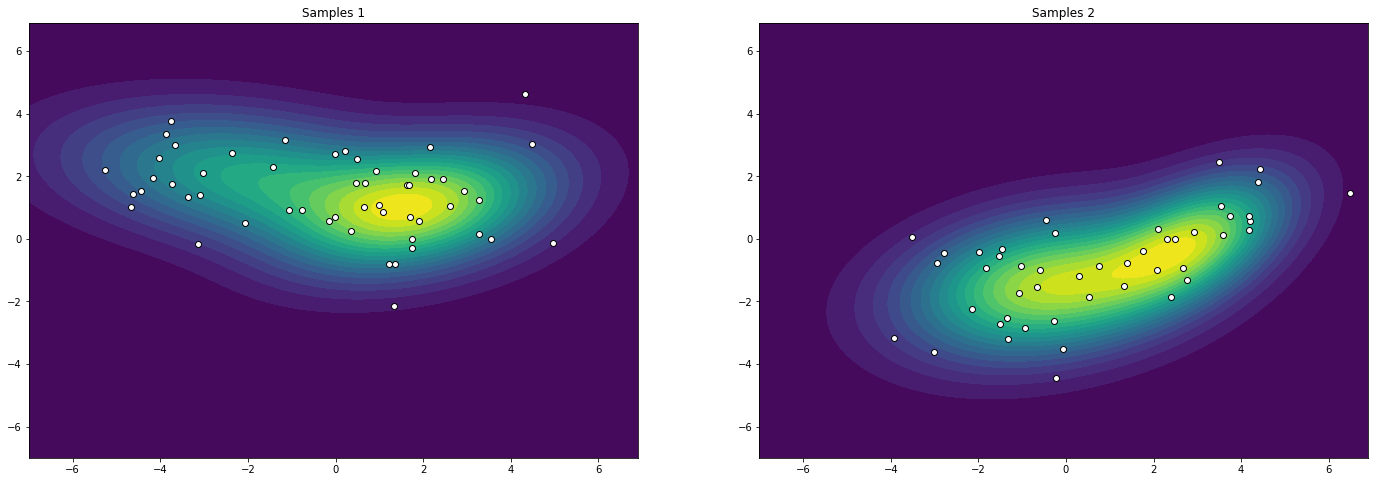

In [277]:
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(121)
ax.set_title('Samples 1')
cs = ax.contourf(x, y, prob_1(pos) , levels=20)
ax.scatter(dataset[dataset[:, 0] == 1, 1], dataset[dataset[:, 0] == 1, 2], c='white', edgecolors='black')

ax2 = fig.add_subplot(122)
ax2.set_title('Samples 2')
cs2 = ax2.contourf(x, y, prob_2(pos) , levels=20)
ax2.scatter(dataset[dataset[:, 0] == 2, 1], dataset[dataset[:, 0] == 2, 2], c='white', edgecolors='black')

plt.show()

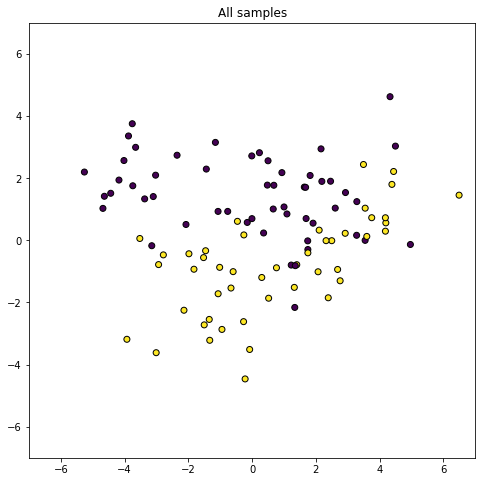

In [278]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title('All samples')

ax.scatter(dataset[:,1],dataset[:,2], c=dataset[:,0], edgecolors='black')
ax.set_xlim(-maxX, maxX)
ax.set_ylim(-maxY, maxY)
plt.show()

In [279]:
n_estimators = 10
clf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)